# Teste de erros em rótulos usando o dataset Iris

Procedimento: Provocar erros propositais nos rótulos do dataset iris do sklearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from ocpc_py import MultiClassPC
import pandas as pd
import os
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from cleanlab import Datalab
from utils.confident_learning import get_CL_label_correction

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Importando o dataset e modificando os rótulos para induzir erro

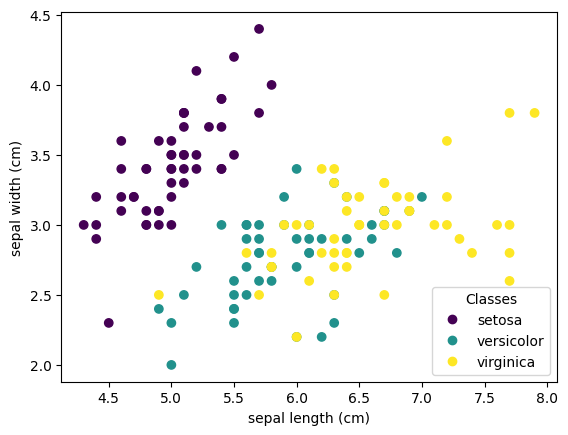

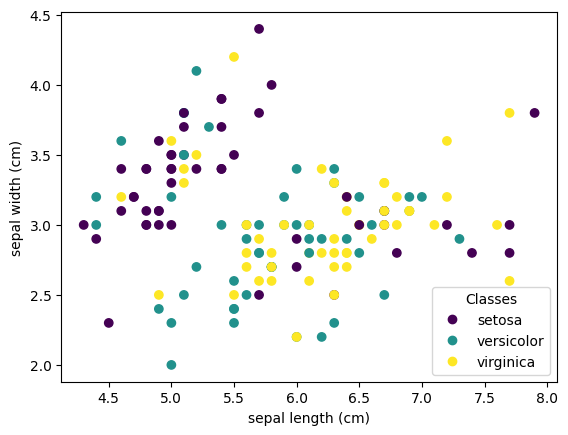

In [3]:
# Importando os dados do dataset
iris = load_iris()
X = iris.data # Features
Y_original = iris.target # Rótulos

def plot_scatter(labels: list, X=X):
    _, ax = plt.subplots()
    scatter = ax.scatter(X[:,0], X[:,1], c=labels)
    ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
    _ = ax.legend(
        scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
    )
    
# Fazer o plot dos dados originais
plot_scatter(labels=Y_original)

# Alterando os dados de Y para causar erros propositais
def alterar_rotulos(Y, percentual, random_state=None):
    np.random.seed(random_state)  # Para reprodutibilidade
    Y_alterado = Y.copy()
    classes = np.unique(Y)

    for classe in classes:
        indices_classe = np.where(Y == classe)[0]  # Obtém índices da classe
        n_alterar = int(len(indices_classe) * percentual)  # 40% dos índices
        indices_escolhidos = np.random.choice(indices_classe, n_alterar, replace=False)

        # Escolher novos rótulos aleatórios, diferentes do original
        for idx in indices_escolhidos:
            novas_classes = np.setdiff1d(classes, Y[idx])  # Evita o mesmo rótulo
            Y_alterado[idx] = np.random.choice(novas_classes)

    return Y_alterado

Y_com_erro = alterar_rotulos(Y_original, 0.3)
    
# Fazer o plot dos dados alterados
plot_scatter(labels=Y_com_erro)


Aplicando a correção de rótulos desenvolvida

In [4]:
Y = Y_com_erro.copy()

# Rodando PCA nos dados
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names) # Cria um dataframe com o dataset de iris

scaler = StandardScaler() # Scaler

iris_scaled = scaler.fit_transform(df_iris) # Normaliza os dados para serem usados dentro do PCA
df_iris_scaled = pd.DataFrame(iris_scaled, columns=iris.feature_names)

pca =  PCA(n_components=3) # Cria o objeto de pca com 2 componentes
pca.fit(iris_scaled) # Faz o PCA com a configuração correta

iris_pca = pca.transform(iris_scaled)

X_copy = X
X = iris_pca.data
Y = np.array(Y, dtype=int).ravel()

clf = MultiClassPC(f=0.8, k_max=3, lamda=0.5, alfa=0.5)
clf.fit(X, Y)

curves_ = clf.curves

# Calcula as distâncias de cada ponto à cada curva
distancias = [curve.map_to_arcl(X) for curve in curves_]
distances = {curve.class_label: curve.map_to_arcl(X) for curve in curves_}

# Junta as informações das distâncias para obter, em cada índice de dados do treinamento as distâncias para cada ponto
data_distances = pd.DataFrame({chave: dado[1] for chave, dado in distances.items()})
data_distances["error_label"] = Y
# Para cada ponto é verificada qual a classe mais próxima e comparada com a classe indicada no início, caso exista algum erro de rótulo o código altera a label do dado para melhor ajustar os dados
rows_to_adjust = []
for i, row in data_distances.iterrows():
    min_dist = row.iloc[:-1].idxmin()
    # Classe cujo ponto tem menor distância
    min_value = row.iloc[:-1].min()
    if row["error_label"] != min_dist:
        rows_to_adjust.append(
            {
                "index": i,
                "error_label": row["error_label"],
                "fixed_label": min_dist,
                "min_distance": min_value,
            }
        )

# Ajustando as labels
for row in rows_to_adjust:
    Y[row["index"]] = row["fixed_label"]
    
fig, ax = plt.subplots()
ax.scatter(X[Y.flatten() == 0][:, 0], X[Y.flatten() == 0][:, 1], color='purple', label='Classe 0 (ajustada)')
ax.scatter(X[Y.flatten() == 1][:, 0], X[Y.flatten() == 1][:, 1], color='green', marker='*', label='Classe 1 (ajustada)')
ax.scatter(X[Y.flatten() == 2][:, 0], X[Y.flatten() == 2][:, 1], color='yellow', marker='*', label='Classe 2 (ajustada)')

# **Desenhando as curvas ajustadas**
curves_[0].plot_curve(ax)
curves_[1].plot_curve(ax)
curves_[2].plot_curve(ax)

avaliation = []
for i in range(len(Y_original)):
    avaliation.append(
        {
            "original": Y_original[i],
            "com_erro": (
                Y_com_erro[i],
                "Correto" if Y_com_erro[i] == Y_original[i] else "Errado",
            ),
            "corrigido": (Y[i], "Correto" if Y[i] == Y_original[i] else "Errado"),
        }
    )


# Salva os dados ajustados em um novo DataFrame
data_distances['original_label'] = Y_original
data_distances["adjusted_label"] = Y
df_dados_ajustados = pd.DataFrame(
    X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])]
)
df_dados_ajustados["Label"] = Y

porcentagem_labels_erradas = (data_distances['error_label'] != data_distances['original_label']).mean()
porcentagem_labels_erradas_depois_do_CL = (data_distances['adjusted_label'] != data_distances['original_label']).mean()
score_correcao = porcentagem_labels_erradas - porcentagem_labels_erradas_depois_do_CL

print(f'porcentagem_labels_erradas: {round(porcentagem_labels_erradas, 2)}%')
print(f'porcentagem_labels_erradas_depois_do_CL: {round(porcentagem_labels_erradas_depois_do_CL, 2)}%')
if score_correcao < 0:
    print(f'Piora de : {round(score_correcao, 2)}%')
elif score_correcao > 0:
    print(f'Melhora de : {round(score_correcao, 2)}%')
else:
    print(f'Sem alteração: {round(score_correcao, 2)}%')
    
# Salvando no CSV
# data_distances.to_excel("resultado_a_analizar.xlsx", index=False)
# df_dados_ajustados.to_excel("dados_ajustados.xlsx", index=False)

print("Resultados salvos no arquivo 'resultado_a_analizar.xlsx'.")
print("Dados ajustados salvos no arquivo 'dados_ajustados.csv'.")

# Comparação com o CL
issues = get_CL_label_correction(X, Y_com_erro, Y_original)

TypeError: only integer scalar arrays can be converted to a scalar index